In [333]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Example: Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{ReLU}}(Z^{[2]}))$$
$$Z^{[3]} = W^{[3]} A^{[2]} + b^{[3]}$$
$$A^{[3]} = g_{\text{softmax}}(Z^{[3]})$$

In [334]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y
    

In [335]:
class Linear:

    def __init__(self,n_inputs,n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.weights = ((np.random.rand(n_inputs,n_outputs) * 2 - 1).T) / 100
        self.biases = ((np.random.rand(1,n_outputs) * 2 -1).T) / 100
    def forward(self,X):
        self.X = X
        self.Z = self.weights @ self.X + self.biases
        return self.Z
    def backward(self,Layer):
        dz_dw = self.X
        dz_db = np.ones_like(Layer.dbackward)
        dz_dA = self.weights
        self.dweights = Layer.dbackward @ dz_dw.T
        self.dbiases = np.mean(Layer.dbackward,axis=1,keepdims=True)
        self.dbackward =dz_dA.T @ Layer.dbackward
class ReLU:
    def forward(self,X):
        self.A = np.maximum(0,X)
        return self.A
        
    def backward(self,Layer):
        dA_dz = np.where(self.A>0,1,0)
        self.dbackward = Layer.dbackward * dA_dz
class Sigmoid:
    def forward(self,X):
        self.A = 1 / (1 + np.exp(-X))
        self.X = X
        return self.A
    def backward(self,Layer):
        dA_dz = self.A * (1-self.A)
        self.dbackward = Layer.dbackward * dA_dz
class SoftMax:
    def forward(self,X):
        A = np.exp(X) / sum(np.exp(X))
        return A
    def backward(self,Layer):
        clone_matrix = np.array*([self.Y,]*len(self.Y))
        jacobian_matrix = np.diag(self.Y) - np.multiply(clone_matrix,clone_matrix.T)
        self.dbackward = Layer.dbackward @ jacobian_matrix
class MSELoss:
    def forward(self,Y_pred,Y_true):
        self.Y_pred = Y_pred
        self.Y_true = Y_true
        self.loss = ((Y_pred-Y_true)**2).mean()
        return self.loss
    def backward(self):
        self.dbackward = 2* (self.Y_pred - self.Y_true)
        
class CategoricalCrossEntropyLoss:
    def forward(self,y_pred,y_true):
        y_pred = np.clip(y_pred,1e-7,1-1e-7)
        self.y_pred = y_pred
        self.y_true = y_true
        # self.loss = -np.log(y_pred[range(len(y_true)),y_true[:]])
        # return self.loss
    def backward(self):
        self.dbackward = (self.y_pred - one_hot(self.y_true)) / len(self.y_pred)
        
    
class OptimizerSGD:
    def __init__(self,lr=0.001):
        self.lr = lr
    def update_params(self,Layer):
        Layer.weights -= self.lr * Layer.dweights
        Layer.biases -= self.lr * Layer.dbiases


In [336]:
def batch_loader(X, y = None, batch_size=64):
  """ Generates batches for training"""
  n_samples = X.shape[0]
  for i in np.arange(0, n_samples, batch_size):
    begin, end = i, min(i + batch_size, n_samples)
    if y is not None:
      yield X[begin:end], y[begin: end]
    else:
      yield X[begin:end]

In [337]:
data = pd.read_csv('train.csv')

In [338]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [339]:
data = np.array(data)
np.random.shuffle(data)
data = data.T
X_train = data[1:].T / 255.
y_train = data[0]

In [340]:
X_train.shape

(42000, 784)

In [341]:
X_val = X_train[:1000][:]
y_val = y_train[:1000]
X_train_new = X_train[1000:][:]
y_train_new = y_train[1000:]

In [342]:
X_val.shape,y_val.shape

((1000, 784), (1000,))

In [343]:
X_train_new.shape,y_train_new.shape

((41000, 784), (41000,))

Label: 7


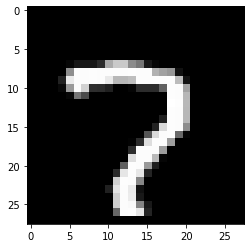

In [344]:
index = 0
plt.gray()
plt.imshow(X_train[index].reshape(28,28),interpolation='nearest')
print(f'Label: {y_train[index]}')

In [345]:
class NeuralNetwork:
    def __init__(self,n_inputs,n_outputs,loss='CategoricalCrossEntropyLoss'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.linear1 = Linear(n_inputs=self.n_inputs,n_outputs=64)
        self.sigmoid1 = ReLU()
        self.linear2 = Linear(n_inputs=64,n_outputs=256)
        self.sigmoid2 = ReLU()
        self.linear3 = Linear(n_inputs=256,n_outputs=self.n_outputs)
        self.softmax = SoftMax()
        self.loss_mode = loss
        if loss=='CategoricalCrossEntropyLoss':
            self.loss = CategoricalCrossEntropyLoss()
        elif loss=="MSELoss":
            self.loss = MSELoss()
    def forward(self,X):
        X = self.linear1.forward(X)
        X = self.sigmoid1.forward(X)
        X = self.linear2.forward(X)
        X = self.sigmoid2.forward(X)
        X = self.linear3.forward(X)
        if self.loss_mode == 'CategoricalCrossEntropyLoss':
            X = self.softmax.forward(X)
        else:
            pass
        return X
    
    def calculate_loss(self,y_pred,y_true):
        self.loss.forward(y_pred,y_true)
        
    def backward(self):
        self.loss.backward()
        self.linear3.backward(self.loss)
        self.sigmoid2.backward(self.linear3)
        self.linear2.backward(self.sigmoid2)
        self.sigmoid1.backward(self.linear2)
        self.linear1.backward(self.sigmoid1)
    
    def update(self):
        optim = OptimizerSGD(lr=self.lr)
        optim.update_params(self.linear1)
        optim.update_params(self.linear2)
        optim.update_params(self.linear3)
    
    def prediction(self,y_pred):
        return np.argmax(y_pred,axis=0)
    def accuracy(self,y_pred,y_true):
        return sum(self.prediction(y_pred)==y_true) / len(y_pred)
    def fit(self,X,y,epochs = 1000,lr=0.1,batch_size=32):
        index = np.random.shuffle(np.arange(len(X)))
        self.lr = lr
        for i in range(epochs):
            index = np.arange(len(X.T))
            np.random.shuffle(index)
            self.X = (X.T[index[:]])
            self.y = y[index[:]]
            for X_batch,y_batch in batch_loader(self.X,self.y,batch_size=batch_size):
                y_pred = self.forward(X_batch.T)
                self.calculate_loss(y_pred,y_batch)
                self.backward()
                self.update()
            if self.loss_mode=='CategoricalCrossEntropyLoss':
                print(f"Epochs{i} : Accuracy :{self.accuracy(self.forward(X_val.T),y_val)}")
            else:
                print(self.forward(self.X).item())         



In [346]:
model = NeuralNetwork(n_inputs=784,n_outputs=10,loss='CategoricalCrossEntropyLoss')


In [347]:
model.fit(X_train_new.T,y_train_new,epochs=20,lr=0.01,batch_size=64)

Epochs0 : Accuracy :23.9
Epochs1 : Accuracy :84.2
Epochs2 : Accuracy :89.1
Epochs3 : Accuracy :89.8
Epochs4 : Accuracy :93.9
Epochs5 : Accuracy :94.3
Epochs6 : Accuracy :94.7
Epochs7 : Accuracy :95.2
Epochs8 : Accuracy :95.3
Epochs9 : Accuracy :94.9
Epochs10 : Accuracy :95.5
Epochs11 : Accuracy :95.9
Epochs12 : Accuracy :96.3
Epochs13 : Accuracy :95.9
Epochs14 : Accuracy :95.9
Epochs15 : Accuracy :96.8
Epochs16 : Accuracy :96.6
Epochs17 : Accuracy :96.5
Epochs18 : Accuracy :97.0
Epochs19 : Accuracy :96.6


In [348]:
data_test = pd.read_csv('test.csv')

In [349]:
data_test = np.array(data_test) / 255
np.random.shuffle(data_test)


In [350]:
X_train.shape[0]

42000

In [351]:
def predict(x):
    return model.prediction(model.forward(x.reshape(-1,1))).item()

<Figure size 432x288 with 0 Axes>

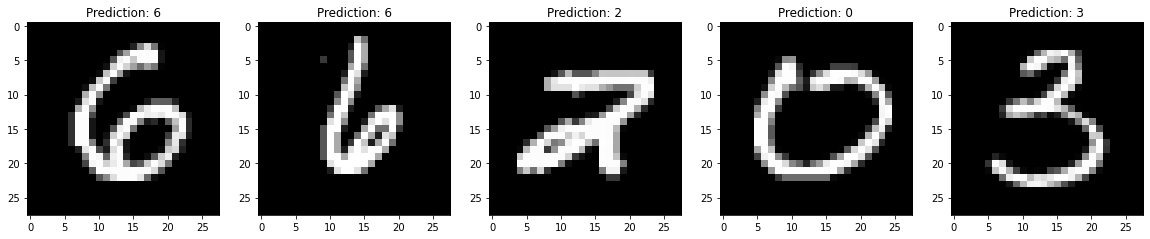

In [352]:
plt.gray()
plt.figure(figsize=(20,8))
num = 5
for i in range(1,num+1):
    plt.subplot(1,num,i)
    plt.imshow(data_test[i].reshape(28,28),interpolation='nearest')
    plt.title(f"Prediction: {predict(data_test[i])}")